Step 4: In this phase different optimizers will be implemented for the 6 models from Step 3.

In [1]:
# Import libraries

import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import plot_model



import tensorflow_datasets as tfds

In [2]:
# Load the data

p_camelyon, p_camelyon_info = tfds.load("patch_camelyon", with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteBDRB4T/patch_camelyon-test.tfrecord


  0%|          | 0/32768 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteBDRB4T/patch_camelyon-train.tfrecord


  0%|          | 0/262144 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteBDRB4T/patch_camelyon-validation.tfrecord


  0%|          | 0/32768 [00:00<?, ? examples/s]

Dataset patch_camelyon downloaded and prepared to /root/tensorflow_datasets/patch_camelyon/2.0.0. Subsequent calls will reuse this data.


In [5]:
# Defining a "normalize" function to process the data before feeding it into the deep neural network. 

def normalize(x):
  image, label = x['image'], x['label']
  image = tf.image.convert_image_dtype(image, tf.float32)
  label = tf.one_hot(label, 2, dtype=tf.float32)
  return image, label

In [6]:
# Applying "normalize" function along with others to the data

# Processing the training dataset
train_ds = p_camelyon['train'].map(normalize, num_parallel_calls=8)
train_ds = train_ds.shuffle(1024)
train_ds = train_ds.repeat()
train_ds = train_ds.batch(128)
train_ds = train_ds.prefetch(2)

# Processing validation dataset
validation_ds = p_camelyon['validation'].map(normalize, num_parallel_calls=8)
validation_ds = validation_ds.repeat()
validation_ds = validation_ds.batch(128)
validation_ds = validation_ds.prefetch(2)

#Processing the test dataset
test_ds = p_camelyon['test'].map(normalize, num_parallel_calls=8)
test_ds = test_ds.batch(128)
test_ds = test_ds.prefetch(2)

#Seperating image and label into different variables
train_images, train_labels = next(iter(train_ds))
valid_images, valid_labels = next(iter(validation_ds))
test_images, test_labels  = next(iter(test_ds))


In [7]:
import math

batch_size_for_training = 64
batch_size_for_validation = 128
batch_size_for_test = 128

training_size = 262144
validation_size = 32768
test_size =  32768
        

# Calculate steps for training and testing the model
calculate_steps_training = lambda x: int(math.ceil(1. * x / batch_size_for_training))
calculate_steps_validation = lambda x: int(math.ceil(1. * x / batch_size_for_validation))
calculate_steps_test= lambda x: int(math.ceil(1. * x / batch_size_for_test))

steps_per_epoch = calculate_steps_training(training_size) 
validation_steps = calculate_steps_validation(validation_size)
steps = calculate_steps_test(test_size)

print("Training steps: ", steps_per_epoch)
print("Validation steps: ", validation_steps)
print("Testing steps: ", steps)


Training steps:  4096
Validation steps:  256
Testing steps:  256


In [8]:
import matplotlib.pyplot as plt

def plot_hist(history):
  plt.plot(history.history["acc"])
  plt.plot(history.history["val_acc"])
  plt.title("Model Accuracy")
  plt.ylabel("Accuracy")
  plt.xlabel("Epochs")
  plt.legend(["train", "validation"], loc="upper left")
  plt.show()

In [38]:
# Building the Convolutonal Nueral Network Model 4.01 (Version 2)

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# Relu activation functions only, with softmax activation function for the last Dense layer
x = Conv2D(16, (3,3), activation='relu', padding='valid')(input)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='valid')(x)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.1)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.1)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = adam
# Loss function = hinge
model_4_01_version_2 = Model(inputs=input, outputs = output)
model_4_01_version_2.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['acc'])

model_4_01_version_2.summary()
#plot_model(model_4_01_version_2)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 conv2d_28 (Conv2D)          (None, 92, 92, 16)        2320      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 46, 46, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 44, 44, 32)        4640      
                                                                 
 conv2d_30 (Conv2D)          (None, 42, 42, 16)        4624      
                                                           

In [39]:
# Building the Convolutonal Nueral Network Model 4.06 (Version 2)

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# Relu activation functions only, with softmax activation function for the last Dense layer
x = Conv2D(16, (3,3), activation='relu', padding='valid')(input)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='valid')(x)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.6)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.6)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = adam
# Loss function = hinge
model_4_06_version_2 = Model(inputs=input, outputs = output)
model_4_06_version_2.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['acc'])

model_4_06_version_2.summary()
#plot_model(model_4_06_version_2)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 conv2d_34 (Conv2D)          (None, 92, 92, 16)        2320      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 46, 46, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 44, 44, 32)        4640      
                                                                 
 conv2d_36 (Conv2D)          (None, 42, 42, 16)        4624      
                                                          

In [40]:
# Building the Convolutonal Nueral Network Model 4.07 (Version 2)

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# Relu activation functions only, with softmax activation function for the last Dense layer
x = Conv2D(16, (3,3), activation='relu', padding='valid')(input)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='valid')(x)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = adam
# Loss function = hinge
model_4_07_version_2 = Model(inputs=input, outputs = output)
model_4_07_version_2.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['acc'])

model_4_07_version_2.summary()
#plot_model(model_4_07_version_2)

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_39 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 conv2d_40 (Conv2D)          (None, 92, 92, 16)        2320      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 46, 46, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 44, 44, 32)        4640      
                                                                 
 conv2d_42 (Conv2D)          (None, 42, 42, 16)        4624      
                                                          

In [41]:
# Building the Convolutonal Nueral Network Model 4.08 (Version 2)

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# Relu activation functions only, with softmax activation function for the last Dense layer
x = Conv2D(16, (3,3), activation='relu', padding='valid')(input)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='valid')(x)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = adam
# Loss function = hinge
model_4_08_version_2 = Model(inputs=input, outputs = output)
model_4_08_version_2.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['acc'])

model_4_08_version_2.summary()
#plot_model(model_4_08_version_2)

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_45 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 conv2d_46 (Conv2D)          (None, 92, 92, 16)        2320      
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 46, 46, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 44, 44, 32)        4640      
                                                                 
 conv2d_48 (Conv2D)          (None, 42, 42, 16)        4624      
                                                          

In [43]:
history_4_01_version_2 = model_4_01_version_2.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)


Epoch 1/10
4096/4096 [==============================] - 159s 39ms/step - loss: 0.1885 - acc: 0.9272 - val_loss: 0.3675 - val_acc: 0.8546
Epoch 2/10
4096/4096 [==============================] - 157s 38ms/step - loss: 0.1679 - acc: 0.9359 - val_loss: 0.4004 - val_acc: 0.8451
Epoch 3/10
4096/4096 [==============================] - 158s 39ms/step - loss: 0.1536 - acc: 0.9413 - val_loss: 0.4485 - val_acc: 0.8331
Epoch 4/10
4096/4096 [==============================] - 158s 38ms/step - loss: 0.1396 - acc: 0.9472 - val_loss: 0.4982 - val_acc: 0.8294
Epoch 5/10
4096/4096 [==============================] - 157s 38ms/step - loss: 0.1257 - acc: 0.9524 - val_loss: 0.4586 - val_acc: 0.8565
Epoch 6/10
4096/4096 [==============================] - 157s 38ms/step - loss: 0.1164 - acc: 0.9561 - val_loss: 0.6402 - val_acc: 0.8302
Epoch 7/10
4096/4096 [==============================] - 158s 38ms/step - loss: 0.1055 - acc: 0.9599 - val_loss: 0.6612 - val_acc: 0.8301
Epoch 8/10
4096/4096 [===================

NameError: ignored

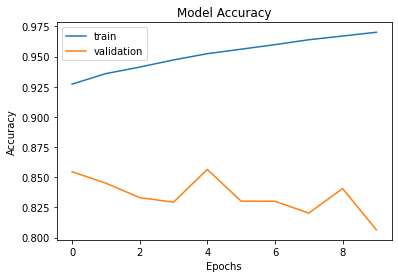

In [44]:
plot_hist(history_4_01_version_2)

In [45]:
history_4_06_version_2 = model_4_06_version_2.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)


Epoch 1/10
4096/4096 [==============================] - 161s 39ms/step - loss: 0.3838 - acc: 0.8326 - val_loss: 0.3292 - val_acc: 0.8531
Epoch 2/10
4096/4096 [==============================] - 157s 38ms/step - loss: 0.2646 - acc: 0.8941 - val_loss: 0.3567 - val_acc: 0.8388
Epoch 3/10
4096/4096 [==============================] - 157s 38ms/step - loss: 0.2254 - acc: 0.9125 - val_loss: 0.3878 - val_acc: 0.8392
Epoch 4/10
4096/4096 [==============================] - 158s 39ms/step - loss: 0.2019 - acc: 0.9231 - val_loss: 0.3411 - val_acc: 0.8580
Epoch 5/10
4096/4096 [==============================] - 180s 44ms/step - loss: 0.1860 - acc: 0.9301 - val_loss: 0.3876 - val_acc: 0.8473
Epoch 6/10
4096/4096 [==============================] - 179s 44ms/step - loss: 0.1741 - acc: 0.9349 - val_loss: 0.6180 - val_acc: 0.7711
Epoch 7/10
4096/4096 [==============================] - 180s 44ms/step - loss: 0.1657 - acc: 0.9380 - val_loss: 0.4311 - val_acc: 0.8401
Epoch 8/10
4096/4096 [===================

NameError: ignored

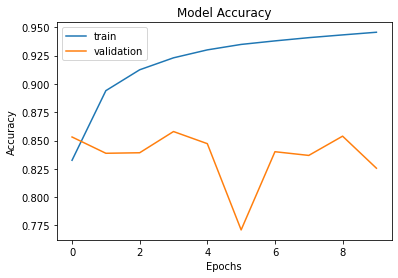

In [46]:
plot_hist(history_4_06_version_2)

Epoch 1/10
4096/4096 [==============================] - 160s 39ms/step - loss: 0.6931 - acc: 0.5011 - val_loss: 0.6932 - val_acc: 0.5005
Epoch 2/10
4096/4096 [==============================] - 156s 38ms/step - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6932 - val_acc: 0.5005
Epoch 3/10
4096/4096 [==============================] - 157s 38ms/step - loss: 0.6932 - acc: 0.4998 - val_loss: 0.6931 - val_acc: 0.5005
Epoch 4/10
4096/4096 [==============================] - 157s 38ms/step - loss: 0.6932 - acc: 0.5002 - val_loss: 0.6932 - val_acc: 0.5005
Epoch 5/10
4096/4096 [==============================] - 180s 44ms/step - loss: 0.6932 - acc: 0.4997 - val_loss: 0.6931 - val_acc: 0.5005
Epoch 6/10
4096/4096 [==============================] - 180s 44ms/step - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6932 - val_acc: 0.5005
Epoch 7/10
4096/4096 [==============================] - 180s 44ms/step - loss: 0.6932 - acc: 0.4998 - val_loss: 0.6932 - val_acc: 0.5005
Epoch 8/10
4096/4096 [===================

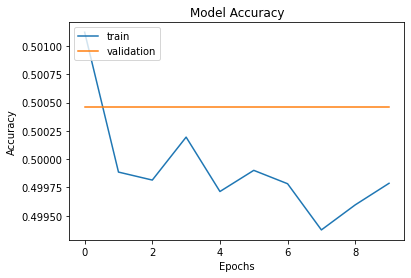

In [47]:
history_4_07_version_2 = model_4_07_version_2.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
plot_hist(history_4_07_version_2)

Epoch 1/10
4096/4096 [==============================] - 159s 38ms/step - loss: 0.3583 - acc: 0.8436 - val_loss: 0.3841 - val_acc: 0.8308
Epoch 2/10
4096/4096 [==============================] - 161s 39ms/step - loss: 0.2482 - acc: 0.9007 - val_loss: 0.3821 - val_acc: 0.8382
Epoch 3/10
4096/4096 [==============================] - 162s 39ms/step - loss: 0.2124 - acc: 0.9179 - val_loss: 0.4243 - val_acc: 0.8245
Epoch 4/10
4096/4096 [==============================] - 164s 40ms/step - loss: 0.1925 - acc: 0.9266 - val_loss: 0.3461 - val_acc: 0.8563
Epoch 5/10
4096/4096 [==============================] - 166s 41ms/step - loss: 0.1773 - acc: 0.9332 - val_loss: 0.3985 - val_acc: 0.8474
Epoch 6/10
4096/4096 [==============================] - 159s 39ms/step - loss: 0.1659 - acc: 0.9379 - val_loss: 0.4169 - val_acc: 0.8445
Epoch 7/10
4096/4096 [==============================] - 167s 41ms/step - loss: 0.1573 - acc: 0.9412 - val_loss: 0.4159 - val_acc: 0.8476
Epoch 8/10
4096/4096 [===================

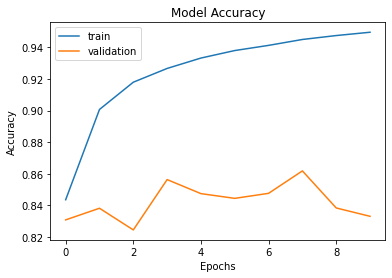

In [48]:
history_4_08_version_2 = model_4_08_version_2.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
plot_hist(history_4_08_version_2)

In [49]:
joblib.dump(model_4_01_version_2, 'model_4_01_version_2')
joblib.dump(model_4_06_version_2, 'model_4_06_version_2')
joblib.dump(model_4_07_version_2, 'model_4_07_version_2')
joblib.dump(model_4_08_version_2, 'model_4_08_version_2')

INFO:tensorflow:Assets written to: ram://e24831c6-1c42-40a5-a7fb-7806c6c0e40c/assets


INFO:tensorflow:Assets written to: ram://e24831c6-1c42-40a5-a7fb-7806c6c0e40c/assets


INFO:tensorflow:Assets written to: ram://a034356b-5f81-4afc-b072-274049f1ac16/assets


INFO:tensorflow:Assets written to: ram://a034356b-5f81-4afc-b072-274049f1ac16/assets


INFO:tensorflow:Assets written to: ram://a06ec3f5-20bd-4d52-a56c-899252d73d17/assets


INFO:tensorflow:Assets written to: ram://a06ec3f5-20bd-4d52-a56c-899252d73d17/assets


INFO:tensorflow:Assets written to: ram://61fa6115-0736-4469-a966-9a786e35f141/assets


INFO:tensorflow:Assets written to: ram://61fa6115-0736-4469-a966-9a786e35f141/assets


['model_4_08_version_2']

In [50]:
model_4_01_version_2_object = joblib.load('model_4_01_version_2')
model_4_06_version_2_object = joblib.load('model_4_06_version_2')
model_4_07_version_2_object = joblib.load('model_4_07_version_2')
model_4_08_version_2_object = joblib.load('model_4_08_version_2')

In [51]:
print("Test dataset accuracy for model 4.01 version 2 is: {0:.4f}".format(model_4_01_version_2_object.evaluate(test_ds, steps=steps, verbose=1)[1]))

256/256 [==============================] - 8s 30ms/step - loss: 0.9919 - acc: 0.7863
Test dataset accuracy for model 4.01 version 2 is: 0.7863


In [52]:
print("Test dataset accuracy for model 4.06 version 2 is: {0:.4f}".format(model_4_06_version_2_object.evaluate(test_ds, steps=steps, verbose=1)[1]))

256/256 [==============================] - 8s 30ms/step - loss: 0.6449 - acc: 0.7979
Test dataset accuracy for model 4.06 version 2 is: 0.7979


In [54]:
print("Test dataset accuracy for model 4.07 version 2 is: {0:.4f}".format(model_4_07_version_2_object.evaluate(test_ds, steps=steps, verbose=1)[1]))

256/256 [==============================] - 8s 31ms/step - loss: 0.6932 - acc: 0.5002
Test dataset accuracy for model 4.07 version 2 is: 0.5002


In [55]:
print("Test dataset accuracy for model 4.08 version 2 is: {0:.4f}".format(model_4_08_version_2_object.evaluate(test_ds, steps=steps, verbose=1)[1]))

256/256 [==============================] - 8s 30ms/step - loss: 0.6654 - acc: 0.7875
Test dataset accuracy for model 4.08 version 2 is: 0.7875
